### Objective

1. Introduce the concept of SSL
2. Compare the performance on CIFAR10 dataset:
    - CNN on small labelled dataset
    - CNN on small labelled dataset + augmentation
    - CNN on small labelled dataset + SSL on large unlabelled dataset
    - CNN on small labelled dataset + SSL on large unlabelled dataset + augmentation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torchsummary
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import timm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

data_path = os.path.expanduser('~/.cache/torch/')

dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)


Files already downloaded and verified


In [4]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/.cache/torch/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

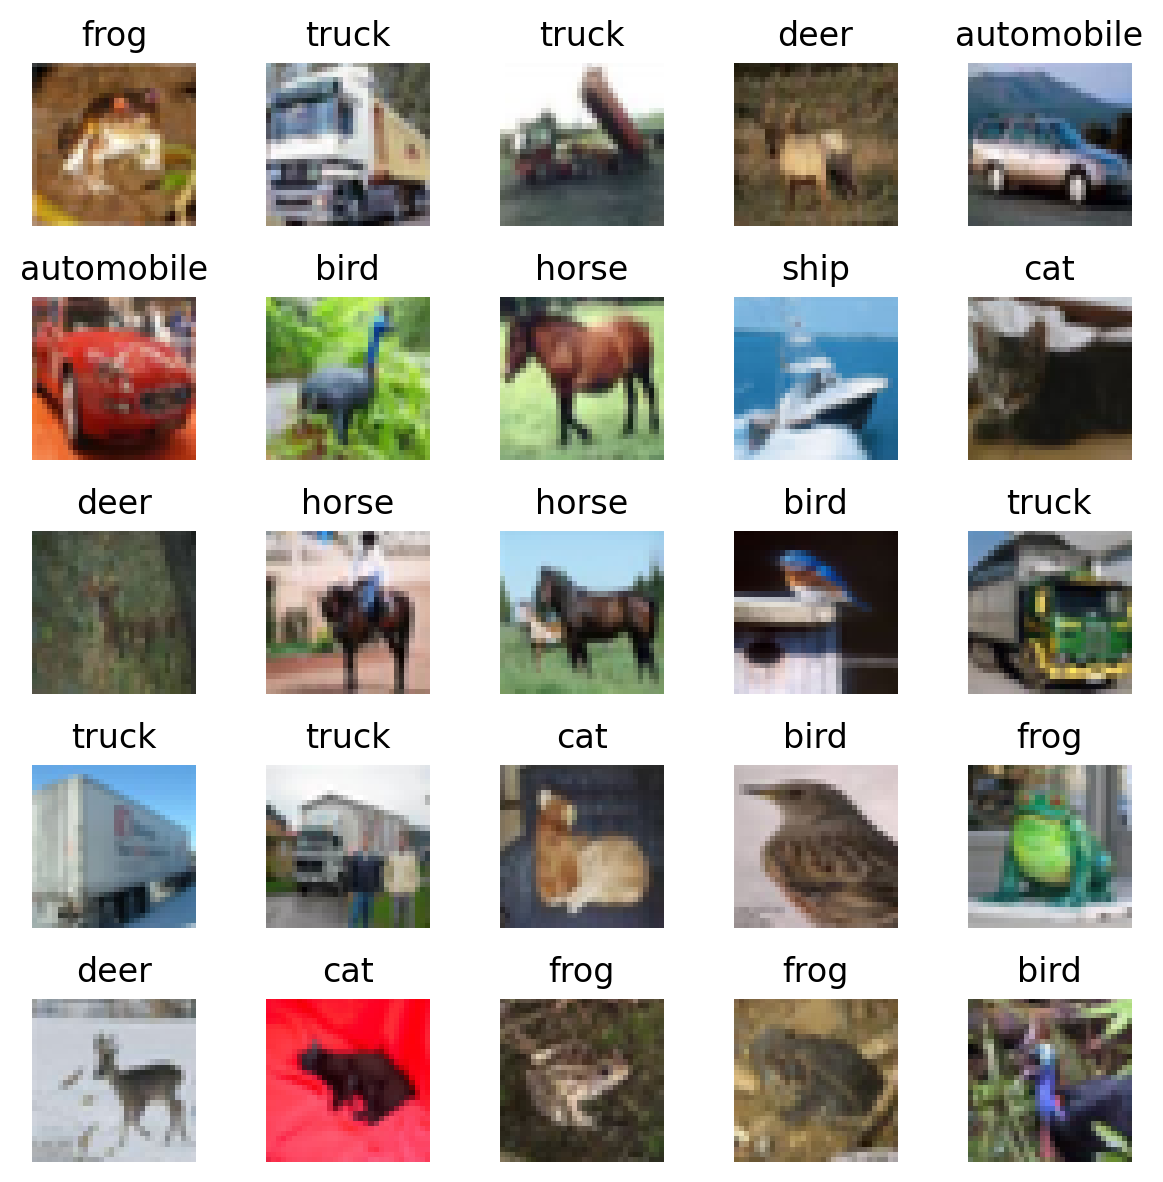

In [6]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(dataset.data[i])
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

In [7]:
# Divide dataset into train, pool and test
train_size = 1000
pool_size = 10000
test_size = len(dataset) - train_size - pool_size

In [8]:
# Create a trainset containing only the first 100 images and test set is everything else

X_train = dataset.data[:train_size]
y_train = dataset.targets[:train_size]

X_pool = dataset.data[train_size:train_size+pool_size]
y_pool = dataset.targets[train_size:train_size+pool_size]

X_test = dataset.data[train_size+pool_size:]
y_test = dataset.targets[train_size+pool_size:]

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.tensor(y_train)

X_pool = torch.from_numpy(X_pool).float()
y_pool = torch.tensor(y_pool)

X_test = torch.from_numpy(X_test).float()
y_test = torch.tensor(y_test)


print(f"train X: {X_train.shape}, y: {y_train.shape}")
print(f"pool X: {X_pool.shape}, y: {y_pool.shape}")
print(f"test X: {X_test.shape}, y: {y_test.shape}")

# But, CNNs expect n_channels x height x width
# So, we need to transpose the data

X_train = X_train.transpose(1, 3)
X_test = X_test.transpose(1, 3)

print()
print("After transposing:")
print(f"train X: {X_train.shape}, y: {y_train.shape}")
print(f"pool X: {X_pool.shape}, y: {y_pool.shape}")
print(f"test X: {X_test.shape}, y: {y_test.shape}")

train X: torch.Size([1000, 32, 32, 3]), y: torch.Size([1000])
pool X: torch.Size([10000, 32, 32, 3]), y: torch.Size([10000])
test X: torch.Size([39000, 32, 32, 3]), y: torch.Size([39000])

After transposing:
train X: torch.Size([1000, 3, 32, 32]), y: torch.Size([1000])
pool X: torch.Size([10000, 32, 32, 3]), y: torch.Size([10000])
test X: torch.Size([39000, 3, 32, 32]), y: torch.Size([39000])


In [9]:
# Scale all input data to [0, 1]

X_train /= 255
X_pool /= 255
X_test /= 255

print(X_train.min(), X_train.max())
print(X_pool.min(), X_pool.max())
print(X_test.min(), X_test.max())

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [10]:
# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.gelu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

    def forward(self, x):
        x = F.gelu(self.fc1(x)) # fc1 -> relu
        x = F.gelu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class Net(nn.Module):
    def __init__(self, random_state=0):
        super().__init__()
        torch.manual_seed(random_state)
        self.featurizer = Featurizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x


In [11]:
net = Net().to(device)

In [12]:
torchsummary.summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
        Featurizer-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
        Classifier-9                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
---------------------------------------------

In [13]:
net

Net(
  (featurizer): Featurizer(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [14]:
net(X_train.to(device)).shape

torch.Size([1000, 10])

In [60]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_pool = X_pool.to(device)
y_pool = y_pool.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [61]:
from astra.torch.utils import train_fn

cnns = {}
results_cnn = {}
for random_seed in range(5):
    print(f"Training CNN with random seed {random_seed}")
    net = Net(random_seed).to(device)
    res_dict = train_fn(net, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=800)
    results_cnn[random_seed] = res_dict
    cnns[random_seed] = net

Training CNN with random seed 0


Loss: 0.068394: 100%|██████████| 800/800 [00:09<00:00, 82.33it/s]


Training CNN with random seed 1


Loss: 1.401269:  23%|██▎       | 186/800 [00:02<00:08, 68.49it/s]

KeyboardInterrupt: 

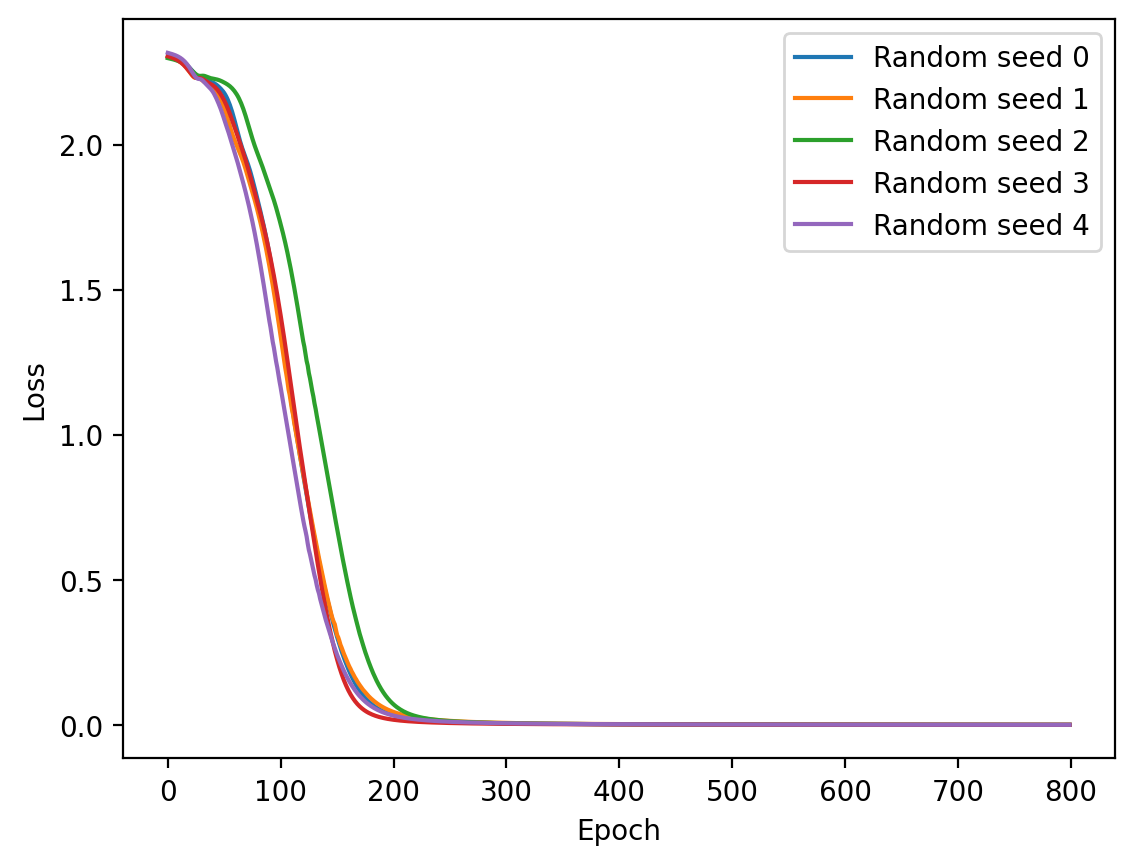

In [27]:
# Plot the losses for all random seeds
for random_seed in range(5):
    plt.plot(results_cnn[random_seed]['epoch_losses'], label=f"Random seed {random_seed}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [62]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    y_pred_train, acc_train = get_accuracy(net, X_train, y_train)
    y_pred_test, acc_test = get_accuracy(net, X_test, y_test)
    print(f'Train accuracy: {acc_train*100:.2f}%')
    print(f'Test accuracy: {acc_test*100:.2f}%')
    if plot_confusion_matrix:
        
        cm_train = confusion_matrix(y_train.cpu(), y_pred_train.cpu())
        cm_test = confusion_matrix(y_test.cpu(), y_pred_test.cpu())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        cm_train_display = ConfusionMatrixDisplay(cm_train, display_labels=classes).plot(values_format='d'
                                                                    , cmap='Blues'
                                                                    , ax=ax1)
        
        cm_test_display = ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(values_format='d'
                                                                    , cmap='Blues'
                                                                    , ax=ax2)

        # Rotate the labels on x-axis to make them readable
        _ = ax1.set_xticklabels(classes, rotation=90)
        _ = ax2.set_xticklabels(classes, rotation=90)
        
        ax1.set_title("Train")
        ax2.set_title("Test")
    return acc_train, acc_test
    

Train accuracy: 51.70%
Test accuracy: 36.36%


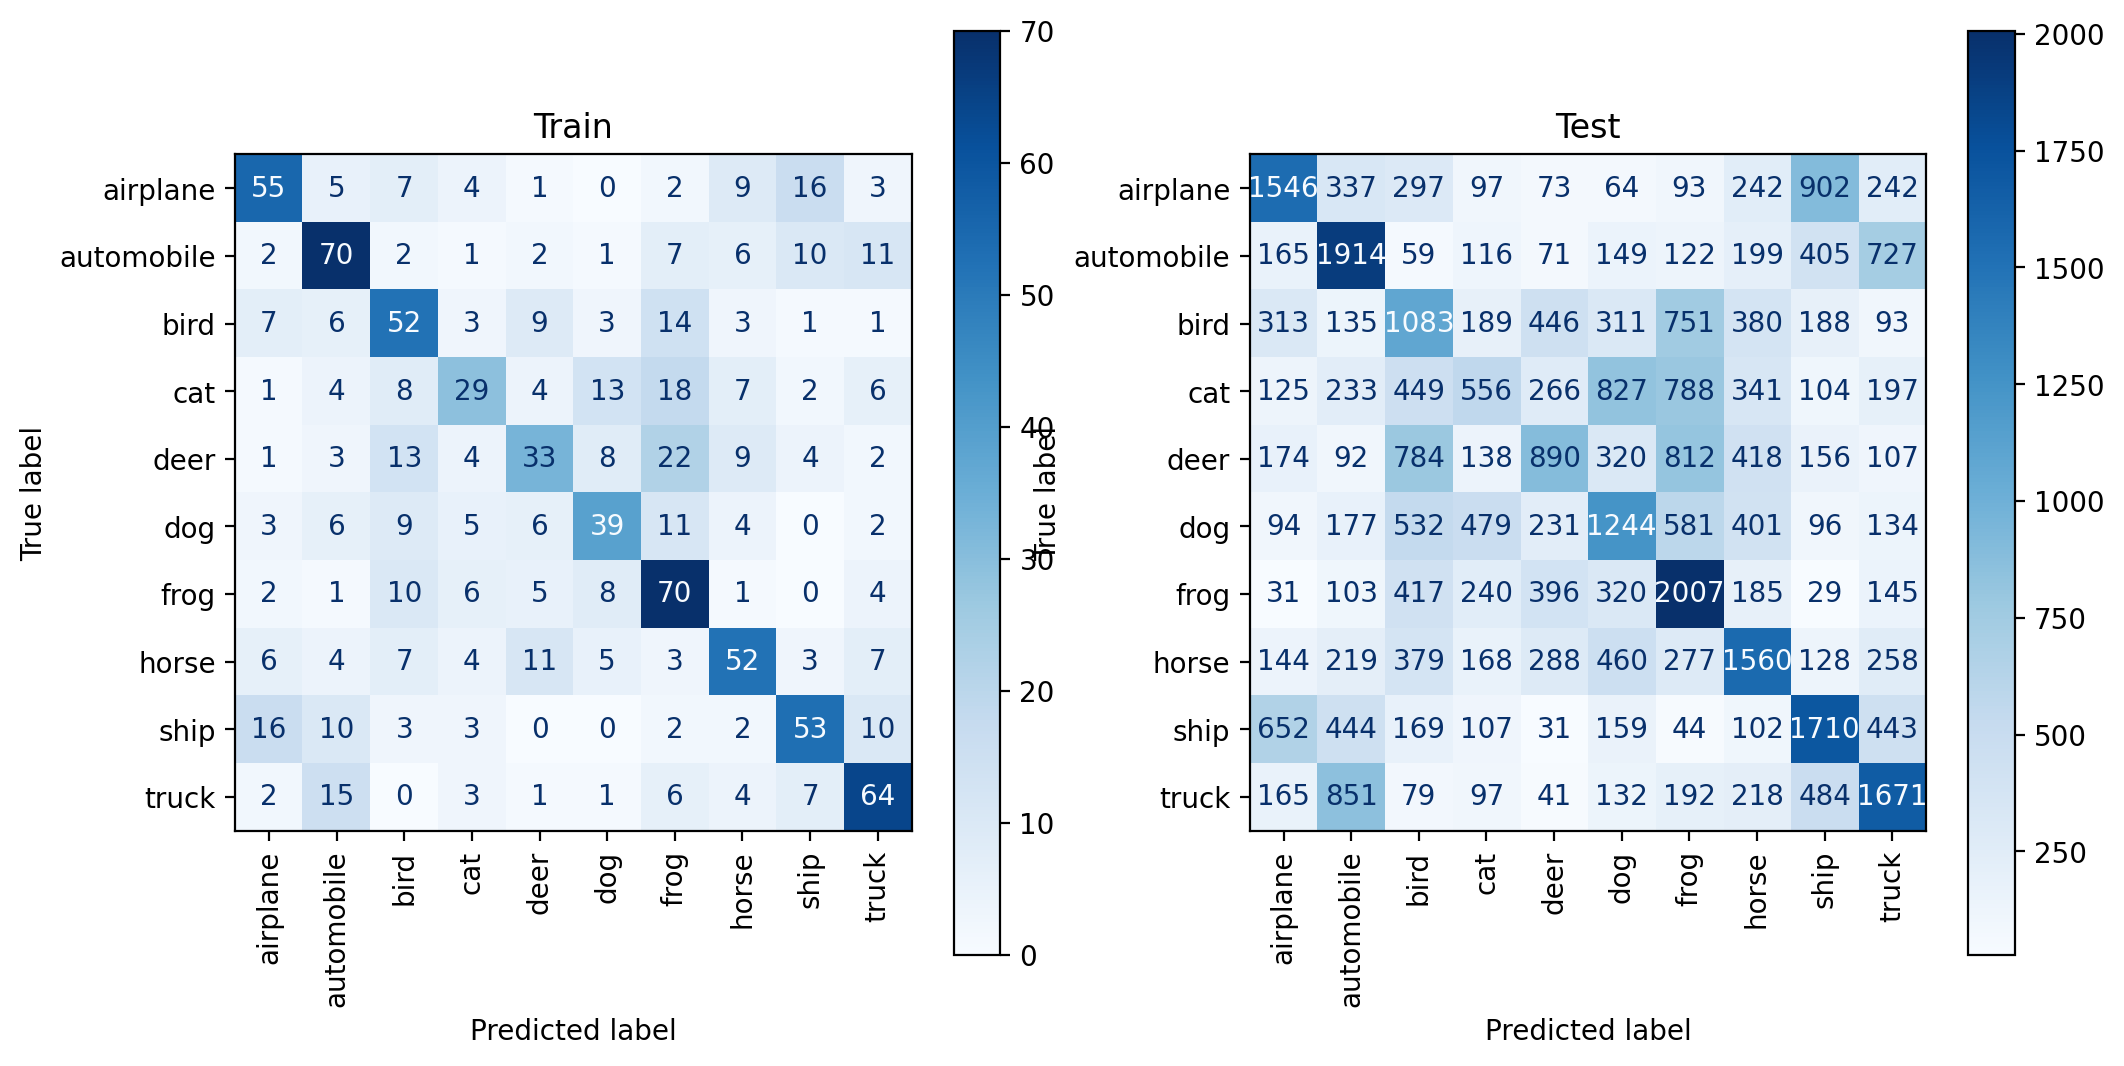

In [63]:
_, _ = predict(net, dataset.classes, True)

In [46]:
# Accuracies across random seeds

accuracies_cnn = {}
for random_seed in range(5):
    acc_train, acc_test = predict(cnns[random_seed], dataset.classes)
    accuracies_cnn[random_seed] = (acc_train.item(), acc_test.item())


Train accuracy: 100.00%
Test accuracy: 19.02%
Train accuracy: 100.00%
Test accuracy: 20.10%
Train accuracy: 100.00%
Test accuracy: 19.74%
Train accuracy: 100.00%
Test accuracy: 19.80%
Train accuracy: 100.00%
Test accuracy: 17.98%


Text(0, 0.5, 'Accuracy')

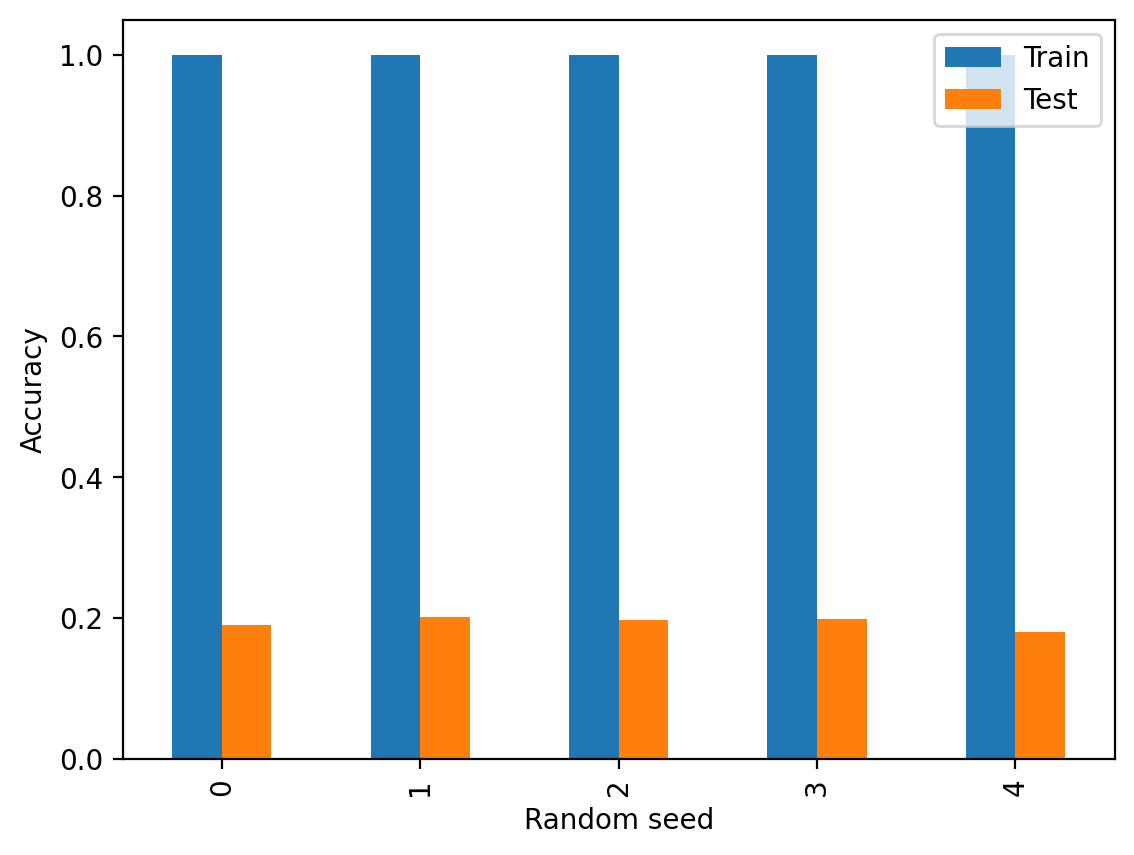

In [50]:
cnn_df = pd.DataFrame(accuracies_cnn, index=['Train', 'Test']).T
# plot
cnn_df.plot(kind='bar')
plt.xlabel("Random seed")
plt.ylabel("Accuracy")

#### TODO

In [64]:
### Creating a (barebones) ResNet model with comparable number of parameters
# Without batchnorm, dropout, etc.

# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class ResidualFeaturizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2) # 3 input channels, 6 output channels, 5x5 kernel
        # Output size = (W - F + 2P)/S + 1 = (32 - 5 + 2*2)/1 + 1 = 32
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        # Output size = (W - F + 2P)/S + 1 = (32 - 5 + 2*2)/1 + 1 = 32
        self.conv3 = nn.Conv2d(16, 16, 5, padding=2)
        self.conv4 = nn.Conv2d(16, 16, 5, padding=2)
        self.conv5 = nn.Conv2d(16, 16, 5, padding=2)
        self.conv6 = nn.Conv2d(16, 16, 5, padding=0)
        self.conv7 = nn.Conv2d(16, 16, 5, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 400) # 16 * 5 * 5 input features, 400 output features
        
    def forward(self, x):
        x1 = F.gelu(self.conv1(x)) # (3, 32, 32) -> (6, 32, 32)
        x2 = F.gelu(self.conv2(x1)) # (6, 32, 32) -> (16, 32, 32)
        x3 = F.gelu(self.conv3(x2)) # (16, 32, 32) -> (16, 32, 32)
        x4 = F.gelu(self.conv4(x3) + x2) # (16, 32, 32) -> (16, 32, 32)
        x5 = F.gelu(self.conv5(x4))
        #x5 = F.gelu(self.conv5(x4) + x3) # (16, 32, 32) -> (16, 32, 32)
        x6 = self.pool(x5) # (16, 32, 32) -> (16, 16, 16)
        x7 = F.gelu(self.conv6(x6)) # (16, 16, 16) -> (16, 12, 12)
        x8 = F.gelu(self.conv7(x7)) # (16, 12, 12) -> (16, 8, 8)
        x9 = F.gelu(self.flatten(x8)) # (16, 8, 8) -> (1024)
        x10 = self.fc1(x9) # (1024) -> (400)
        
        return x10

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = ResidualFeaturizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x


In [65]:
res_feat = ResidualFeaturizer().to(device)
print(res_feat(torch.randn(1, 3, 32, 32).to(device)).shape)

res_net = ResNet().to(device)
print(res_net(torch.randn(1, 3, 32, 32).to(device)).shape)

torch.Size([1, 400])
torch.Size([1, 10])


In [66]:
torchsummary.summary(res_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
            Conv2d-2           [-1, 16, 32, 32]           2,416
            Conv2d-3           [-1, 16, 32, 32]           6,416
            Conv2d-4           [-1, 16, 32, 32]           6,416
            Conv2d-5           [-1, 16, 32, 32]           6,416
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 16, 12, 12]           6,416
            Conv2d-8             [-1, 16, 8, 8]           6,416
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 400]         410,000
ResidualFeaturizer-11                  [-1, 400]               0
           Linear-12                  [-1, 120]          48,120
           Linear-13                   [-1, 84]          10,164
           Linear-14                  

In [67]:
res_net = ResNet().to(device)
res_dict = train_fn(res_net, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=1500)

KeyboardInterrupt: 

In [68]:
predict(res_net, dataset.classes)

Train accuracy: 100.00%
Test accuracy: 25.90%


(tensor(1., device='cuda:0'), tensor(0.2590, device='cuda:0'))

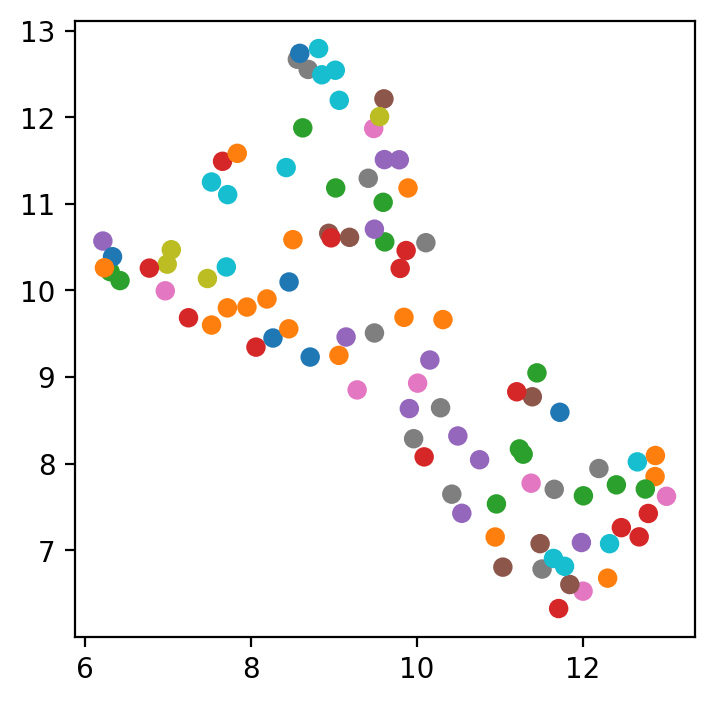

In [37]:
import umap
def viz_embeddings(net, X, y):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X)
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')

viz_embeddings(net, X_train, y_train)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

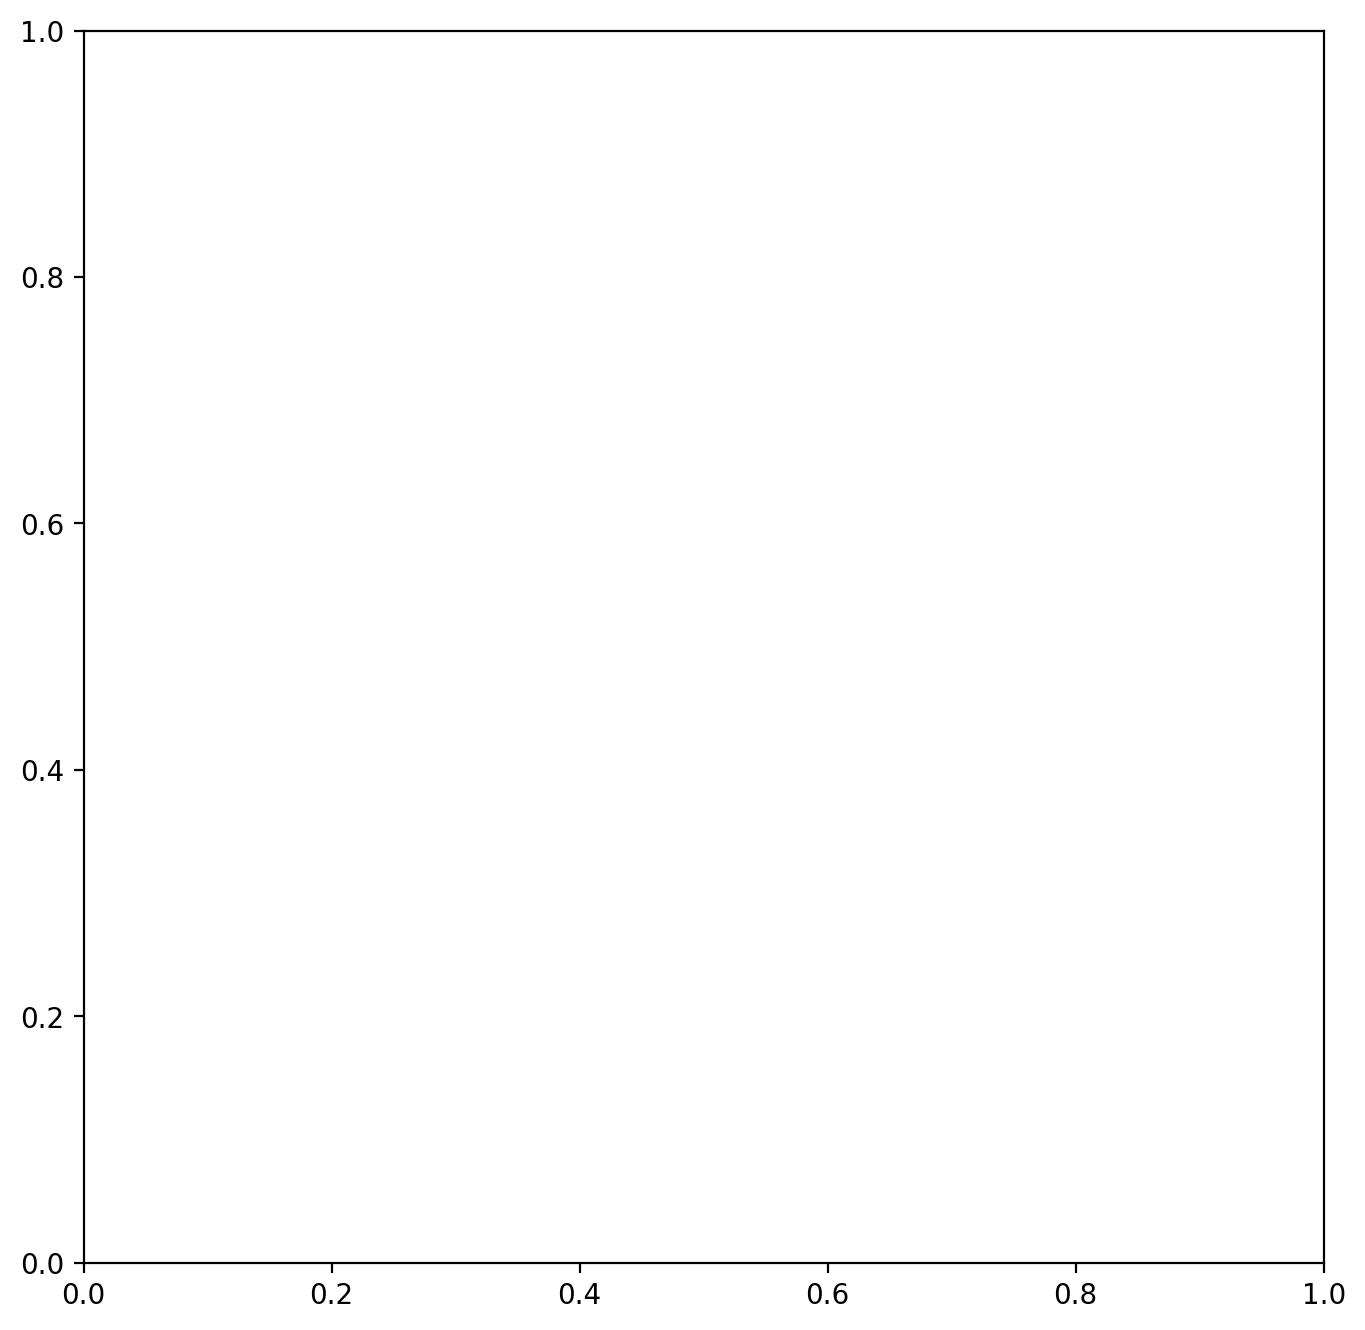

In [22]:
viz_embeddings(net, X_train, y_train)

In [23]:
with torch.no_grad():
    emb = net.featurizer(X_train)
    emb = emb.cpu().numpy()


In [24]:
type(emb)

numpy.ndarray

In [25]:
import sklearn
sklearn.__version__

'1.3.2'

In [26]:
ts = TSNE(n_components=2, random_state=0)
z = ts.fit_transform(emb)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


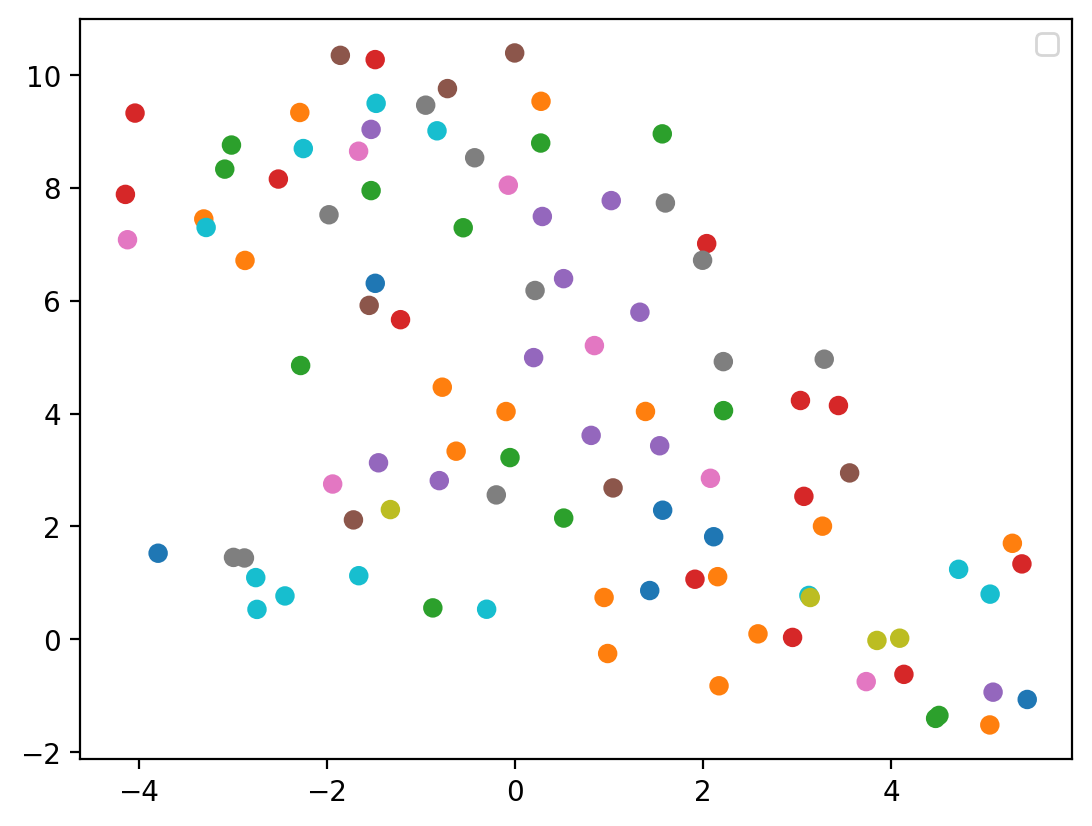

In [30]:
plt.scatter(z[:, 0], z[:, 1], c=y_train.cpu().numpy(), cmap='tab10')
plt.legend()

In [58]:
# Print CUDA version
print(torch.version.cuda)

11.8


In [33]:
import umap

In [34]:
reducer = umap.UMAP()
with torch.no_grad():
    emb = net.featurizer(X_train)
    emb = emb.cpu().numpy()
    z = reducer.fit_transform(emb)


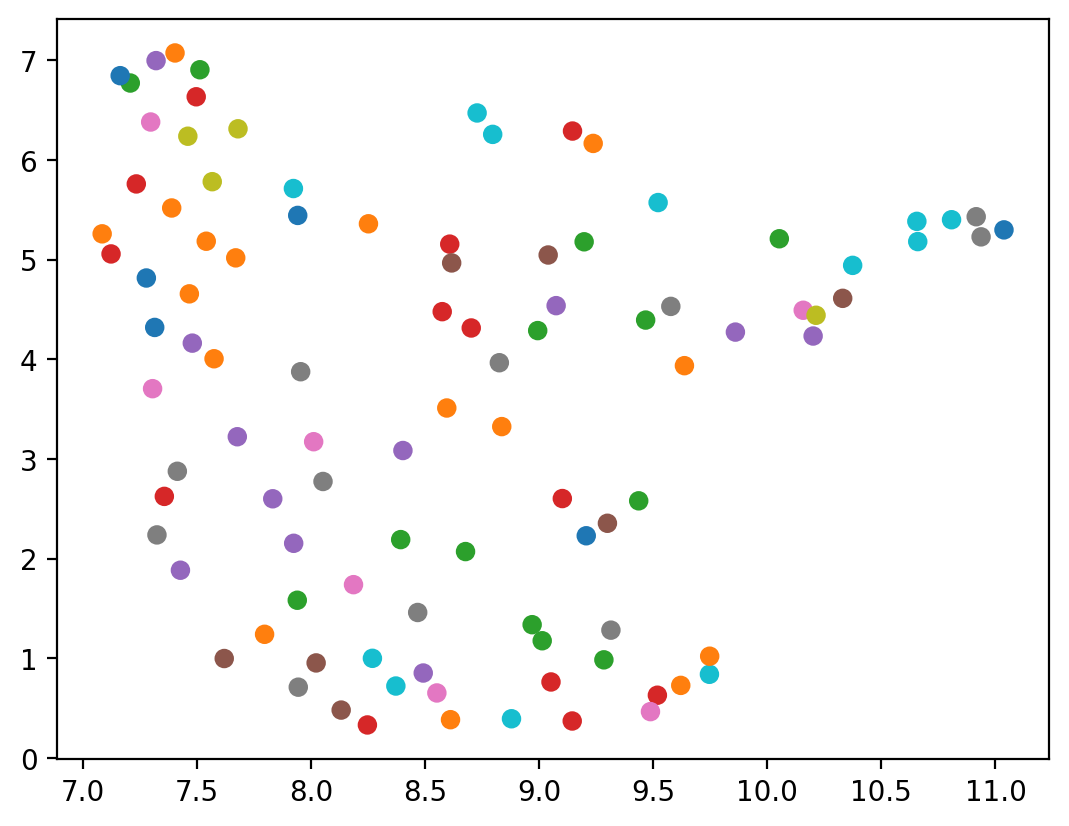

In [35]:
plt.scatter(z[:, 0], z[:, 1], c=y_train.cpu().numpy(), cmap='tab10')

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

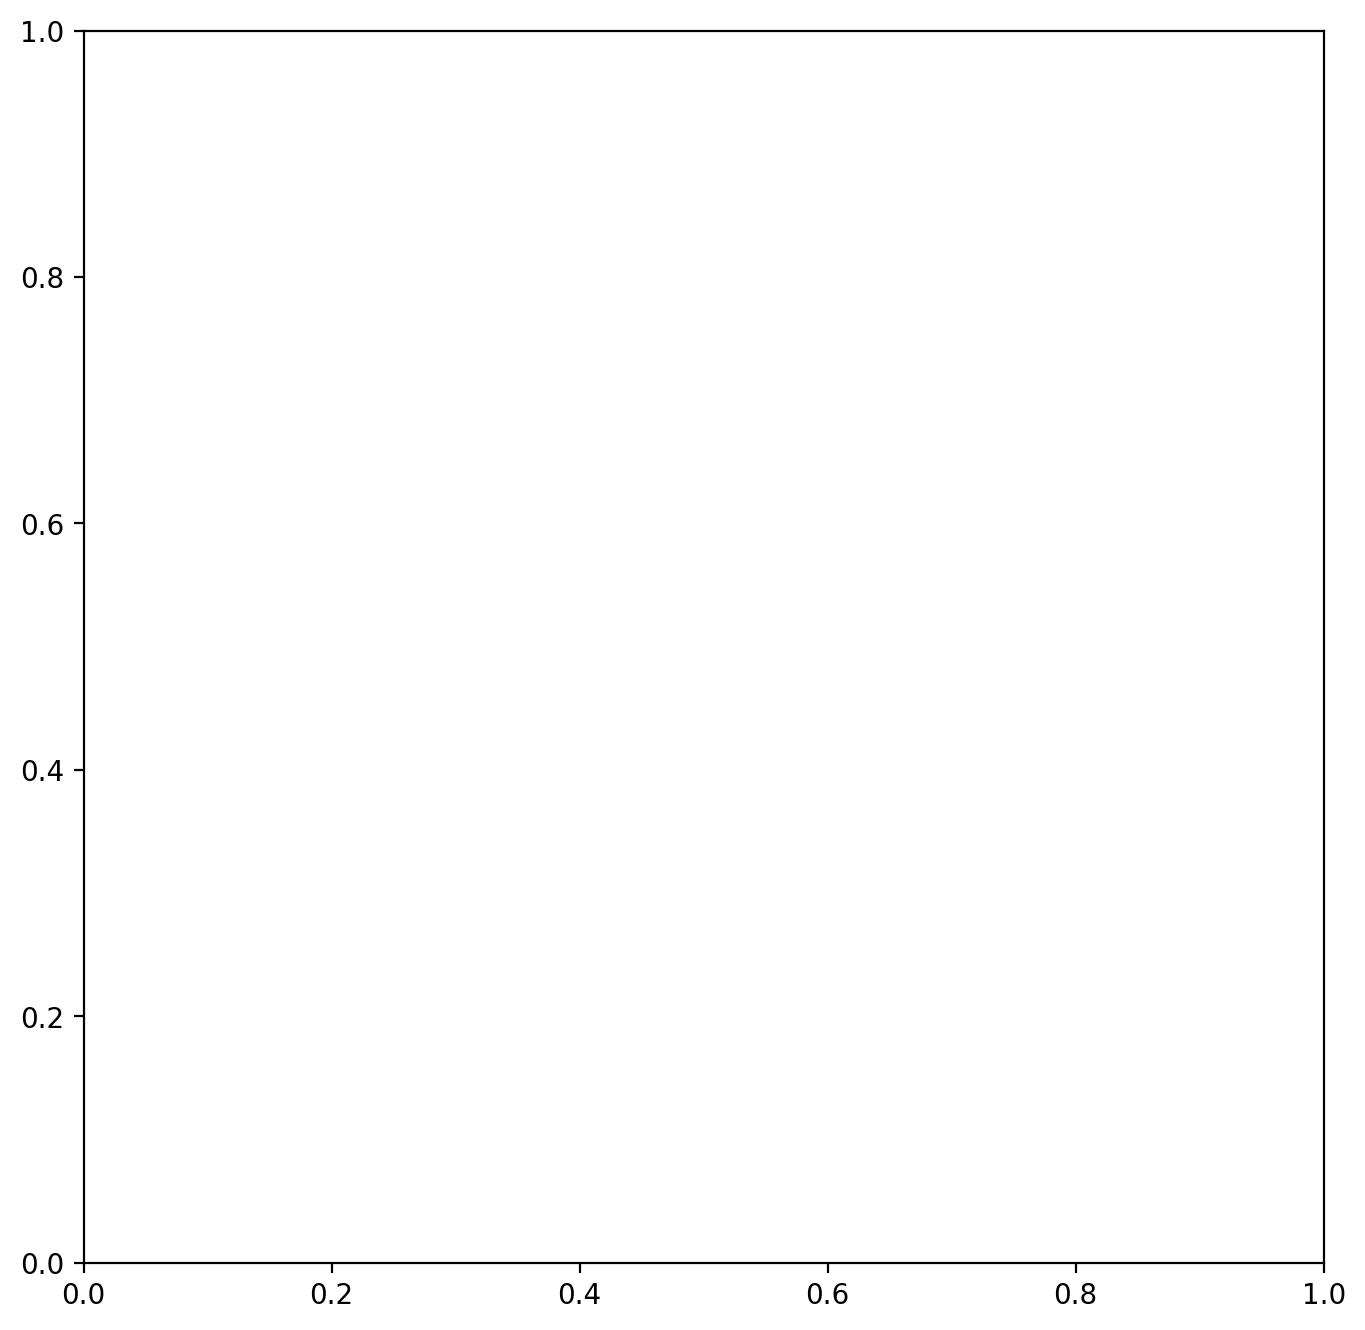

In [57]:
viz_embeddings(net, X_train, y_train)

In [69]:
rn = timm.create_model('resnet18', pretrained=False, num_classes=10).to(device)

In [70]:
torchsummary.summary(rn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
          Identity-7             [-1, 64, 8, 8]               0
              ReLU-8             [-1, 64, 8, 8]               0
          Identity-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          36,864
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
       BasicBlock-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [71]:
rn = timm.create_model('resnet18', pretrained=False, num_classes=10).to(device)
res_dict = train_fn(rn, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)





























Loss: 1.401269:  23%|██▎       | 186/800 [01:41<05:36,  1.82it/s]






















































































































































































































































































































































































































































































































































































































Loss: 0.000309: 100%|██████████| 500/500 [00:13<00:00, 35.73it/s]


In [72]:
predict(rn, dataset.classes)

Train accuracy: 100.00%
Test accuracy: 37.28%


(tensor(1., device='cuda:0'), tensor(0.3728, device='cuda:0'))

In [73]:
# Define data augmentation transformations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(2),
    #transforms.RandomVerticalFlip(),
])

In [74]:
def plot_orginal_and_augmented_images(image_id):
    # Function to plot images in one row
    def plot_images(images, titles):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        for i in range(len(images)):
            axes[i].imshow(images[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
        plt.show()

    # Select the original image and create augmented images
    original_image = X_train[image_id].permute(1, 2, 0).cpu().numpy() 

    # Create a list to store augmented images
    augmented_images = [original_image]
    augmented_titles = ["Original Image"]

    # Apply augmentations and add the transformed images to the list
    for _ in range(5):
        transformed_image = augmentation(X_train[image_id]).permute(1, 2, 0).cpu().numpy() 
        augmented_images.append(transformed_image)
        augmented_titles.append("Augmented Image")

    # Plot the original image and augmented images in one row
    plot_images(augmented_images, augmented_titles)


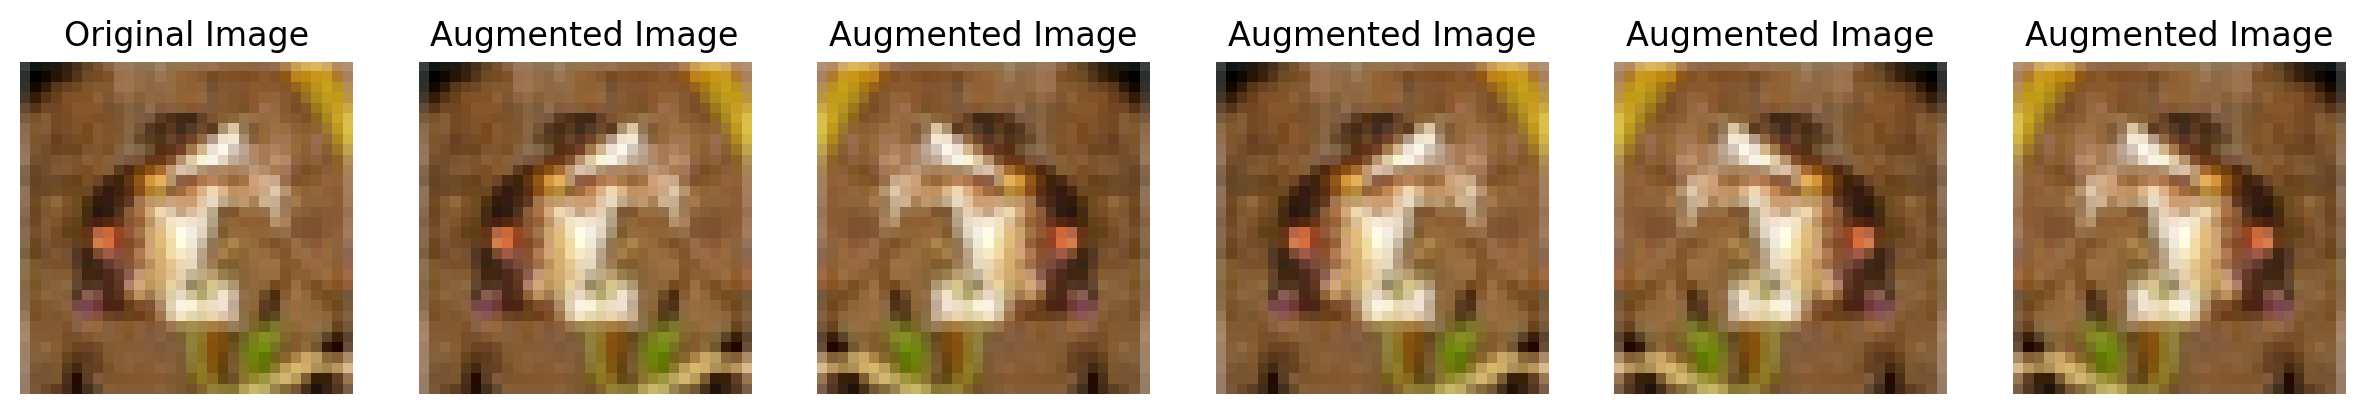

In [75]:
plot_orginal_and_augmented_images(0)

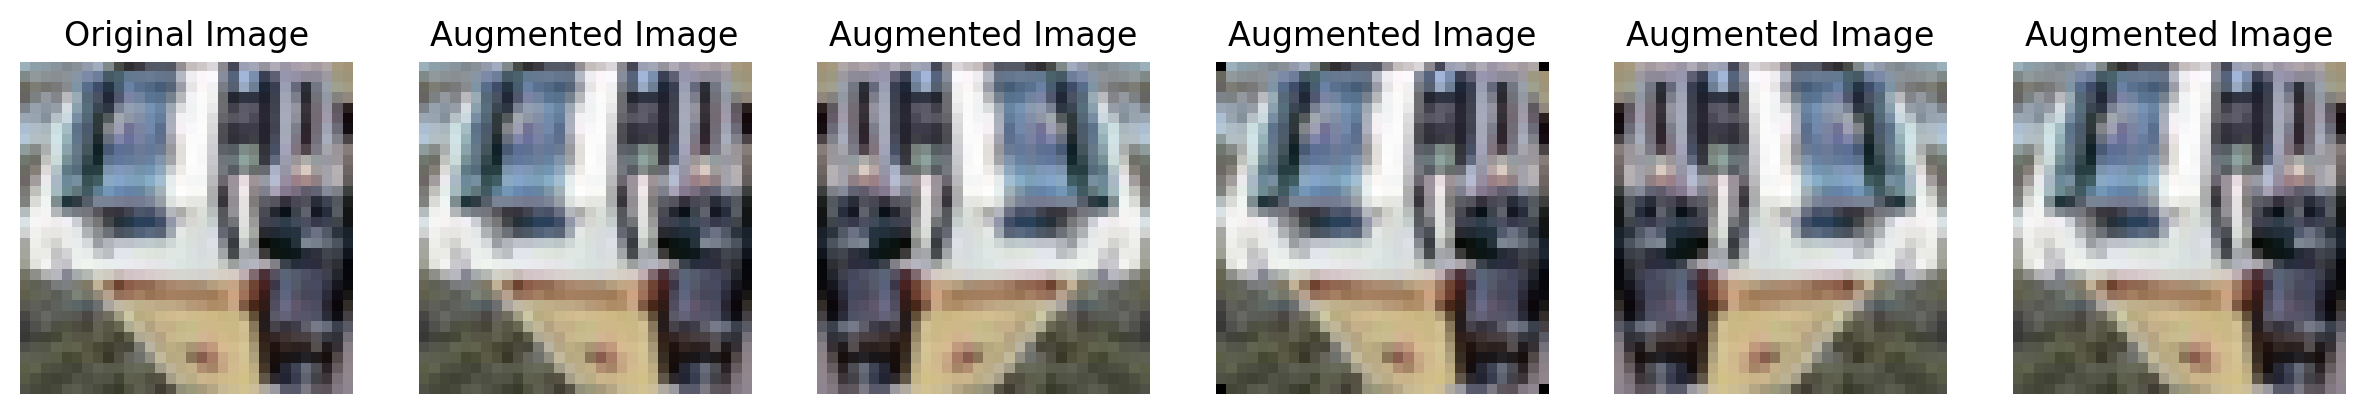

In [76]:
plot_orginal_and_augmented_images(1)

In [77]:
# Create augmented dataset with 5 augmented images per original image

X_augmented = []
y_augmented = []

# Number of augmented images per original image
num_augmentations = 10

for i in range(len(X_train)):
    for _ in range(num_augmentations):
        augmented_image = augmentation(X_train[i]).permute(1, 2, 0).cpu().numpy() 
        X_augmented.append(augmented_image)
        y_augmented.append(y_train[i].cpu())

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)
# Convert the lists to tensors
X_augmented = torch.from_numpy(X_augmented).float()
y_augmented = torch.tensor(y_augmented)

print(X_augmented.shape, y_augmented.shape)
    

torch.Size([10000, 32, 32, 3]) torch.Size([10000])


In [78]:
# Get X_augmented and y_augmented to the device and in correct shape
X_augmented = X_augmented.to(device).transpose(1, 3)
y_augmented = y_augmented.to(device)

print(X_augmented.shape, y_augmented.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [79]:
# Stack the original and augmented data
X_train_augmented = torch.cat([X_train, X_augmented])
y_train_augmented = torch.cat([y_train, y_augmented])

print(X_train_augmented.shape, y_train_augmented.shape)

torch.Size([11000, 3, 32, 32]) torch.Size([11000])


In [80]:
net = Net().to(device)
res_dict = train_fn(net, X_train_augmented, y_train_augmented, 
                    nn.CrossEntropyLoss(), lr=3e-4, n_epochs=1000)

Loss: 0.594509: 100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


Train accuracy: 100.00%
Test accuracy: 17.65%


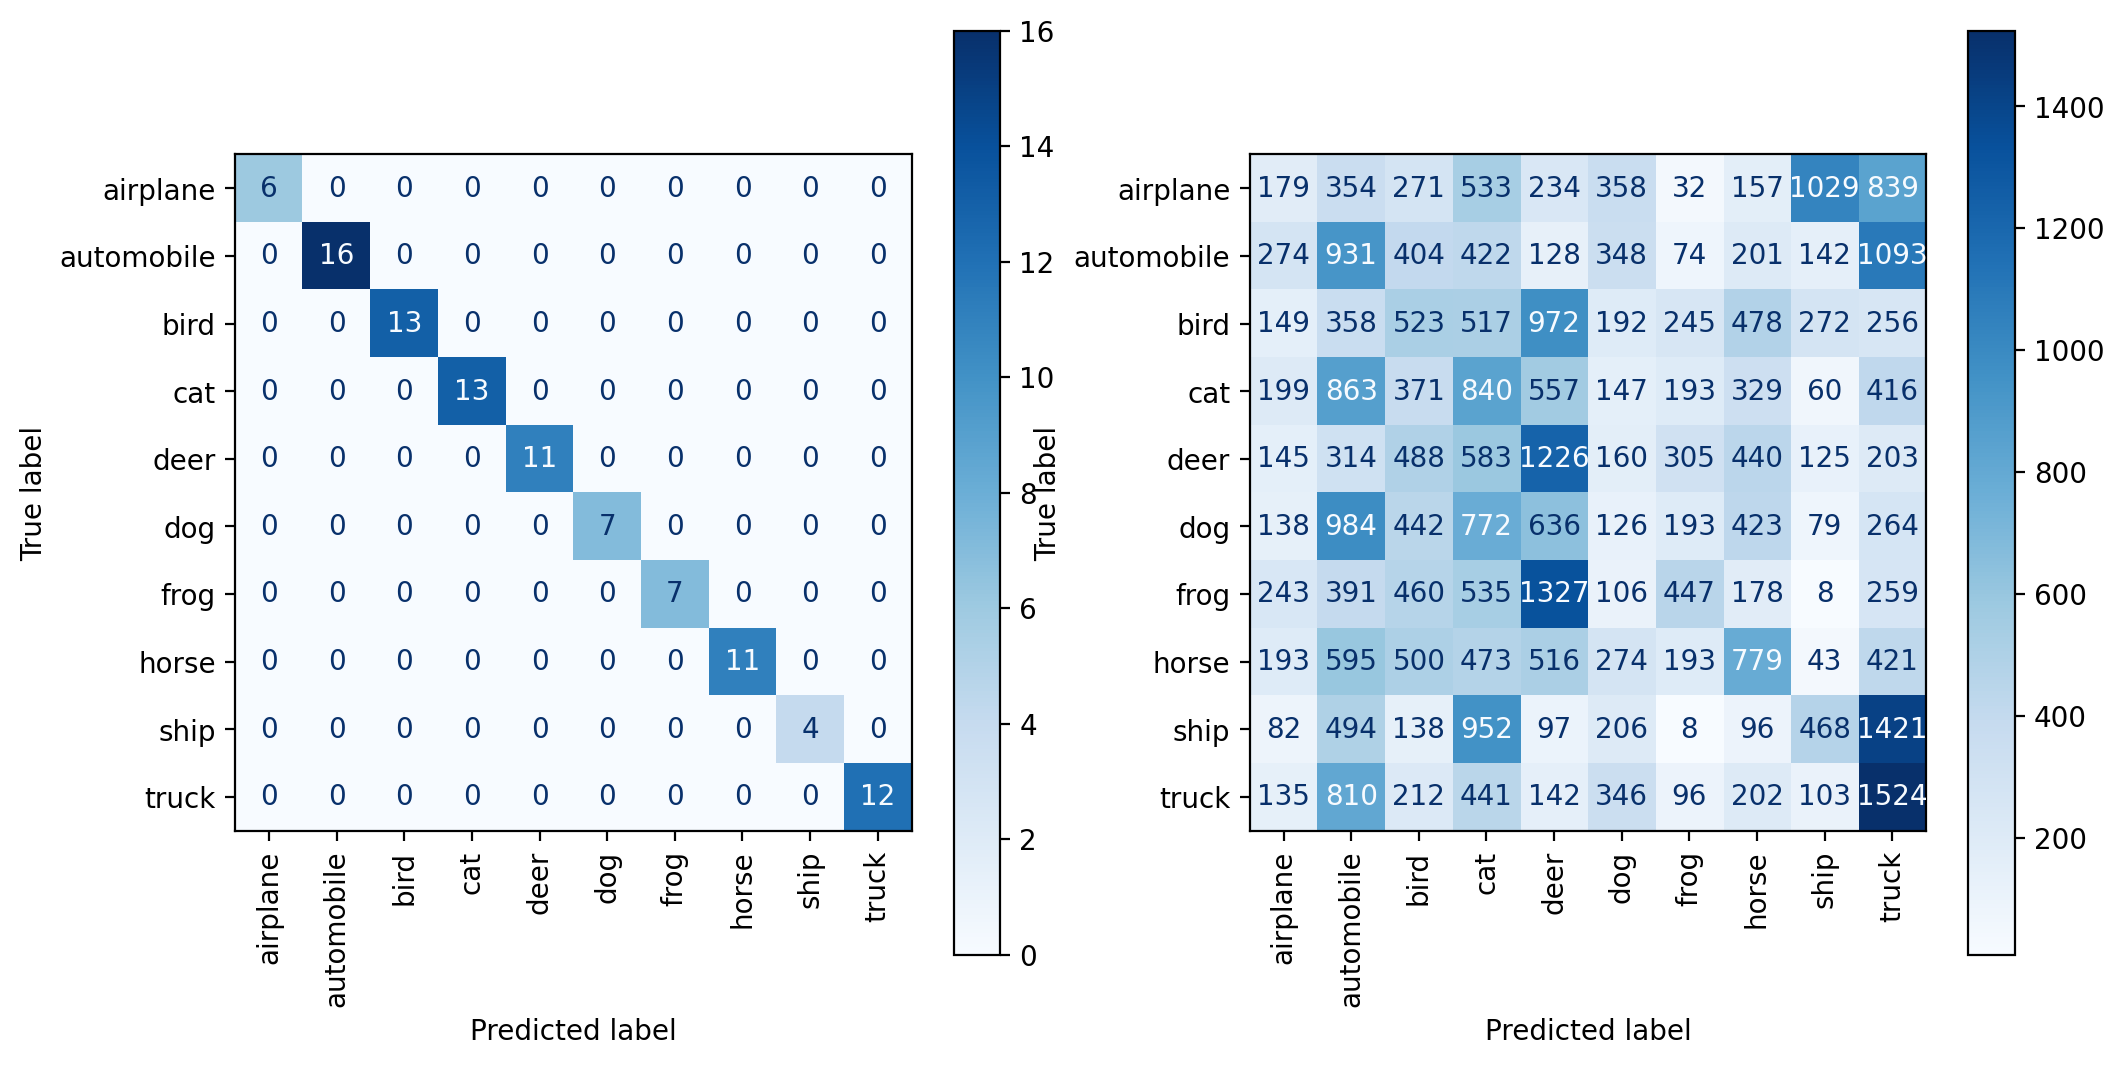

In [50]:
predict(net, dataset.classes)

In [51]:
rn = timm.create_model('resnet34', pretrained=False, num_classes=10).to(device)
res_dict = train_fn(rn, X_train_augmented, y_train_augmented,
                    nn.CrossEntropyLoss(), lr=3e-4, n_epochs=1000)

Loss: 0.000095: 100%|██████████| 1000/1000 [00:33<00:00, 29.78it/s]


In [81]:
predict(rn, dataset.classes)

Train accuracy: 100.00%
Test accuracy: 37.28%


(tensor(1., device='cuda:0'), tensor(0.3728, device='cuda:0'))

In [53]:
res_net = ResNet().to(device)
res_dict = train_fn(res_net, X_train_augmented, y_train_augmented, 
                    nn.CrossEntropyLoss(), lr=3e-4, n_epochs=1000)

Loss: 0.586089: 100%|██████████| 1000/1000 [00:29<00:00, 33.97it/s]


Train accuracy: 58.00%
Test accuracy: 15.68%


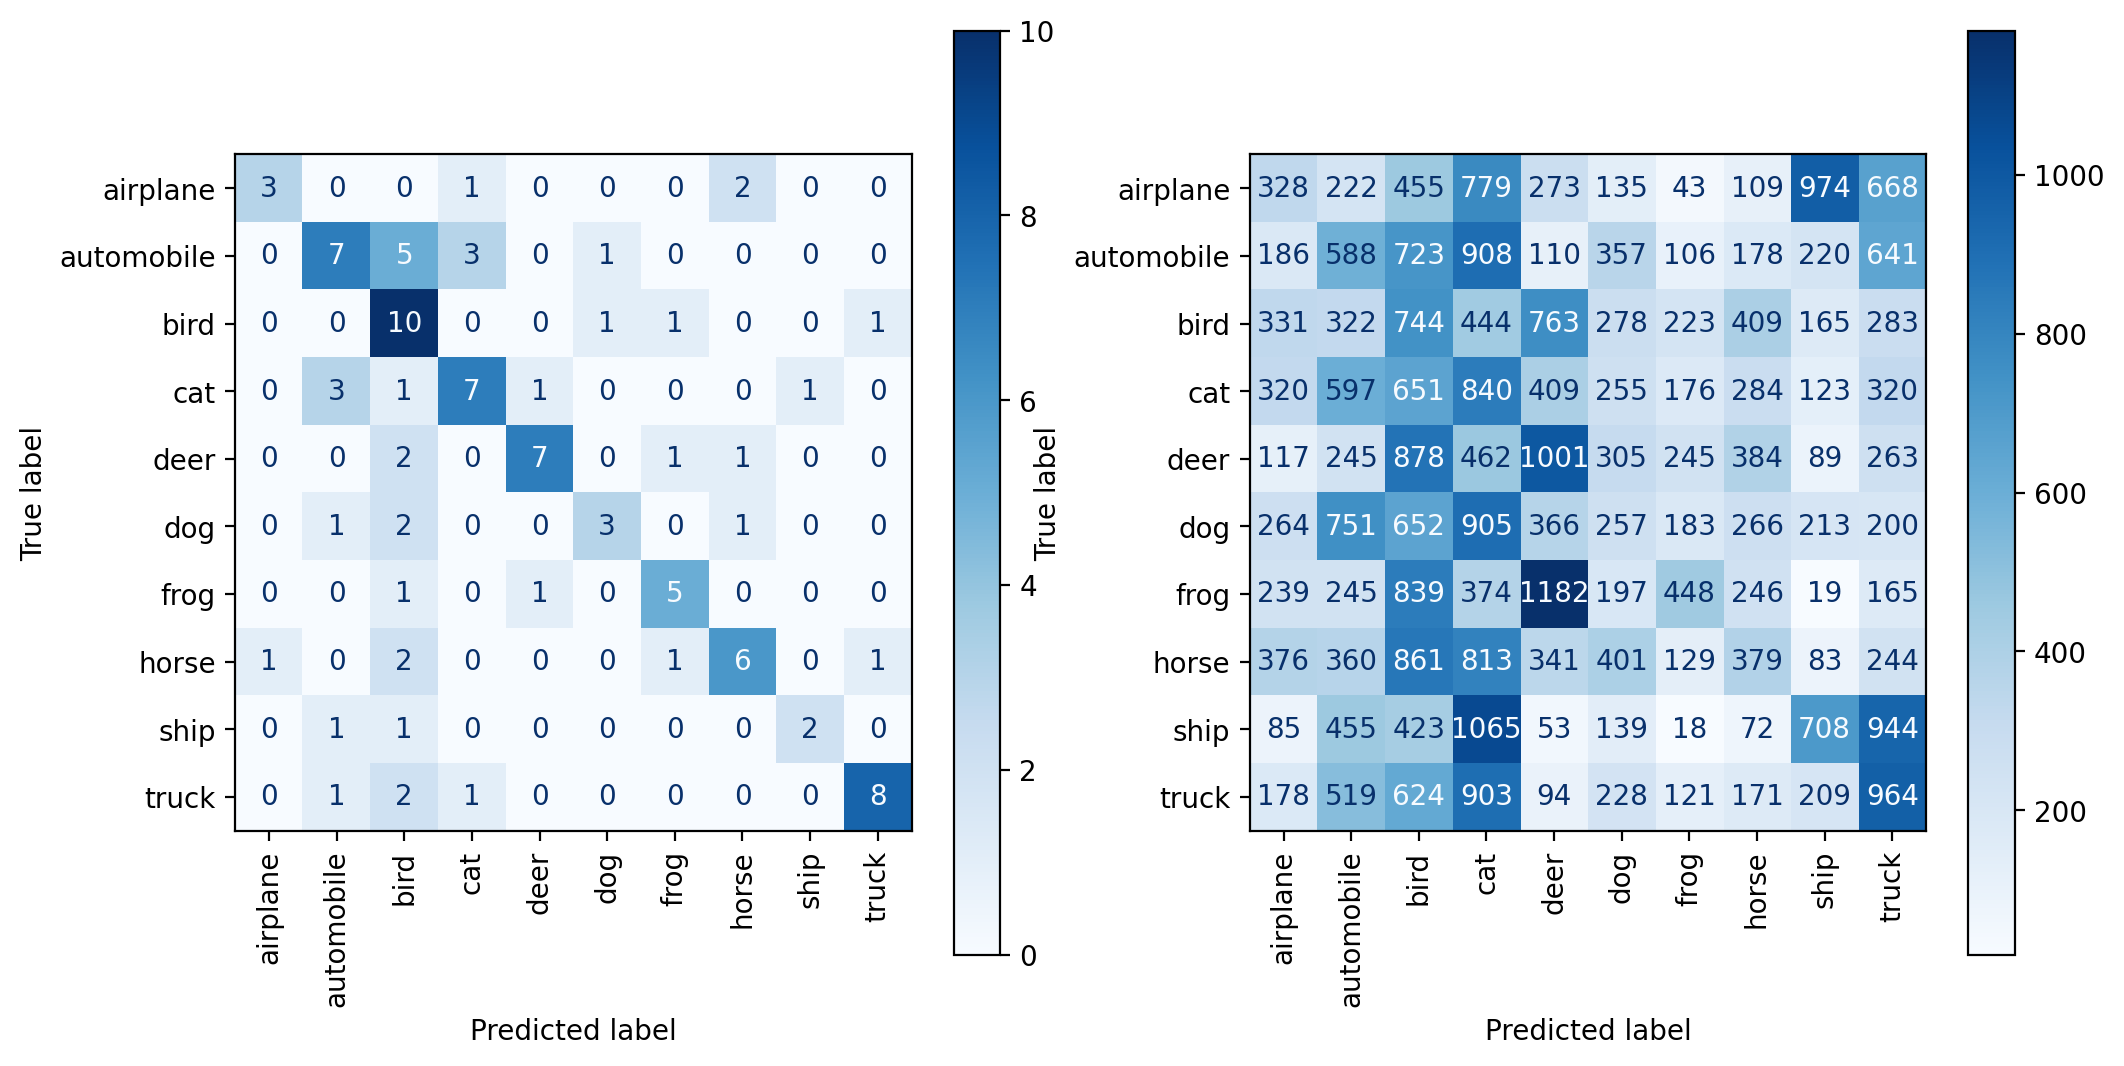

In [54]:
predict(res_net, dataset.classes)

In [51]:
import pandas as pd
pd.DataFrame(X_train[0][0].cpu()).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.510539,0.418137,0.441912,0.454289,0.437500,0.402328,0.418015,0.455392,0.455515,0.464461,...,0.580882,0.571691,0.584681,0.586029,0.587500,0.572181,0.558701,0.554167,0.554289,0.628431
std,0.126123,0.137375,0.116168,0.096425,0.088488,0.102087,0.103764,0.138375,0.151614,0.109858,...,0.097018,0.125335,0.134465,0.084196,0.089033,0.107951,0.136913,0.148528,0.152076,0.128834
min,0.168627,0.000000,0.062745,0.129412,0.196078,0.125490,0.227451,0.160784,0.172549,0.243137,...,0.423529,0.329412,0.301961,0.474510,0.458824,0.278431,0.129412,0.196078,0.133333,0.360784
25%,0.501961,0.414706,0.437255,0.439216,0.412745,0.345098,0.340196,0.399020,0.328431,0.391176,...,0.528431,0.532353,0.514706,0.529412,0.523529,0.525490,0.498039,0.529412,0.504902,0.560784
50%,0.545098,0.468627,0.476471,0.476471,0.468627,0.419608,0.429412,0.486275,0.494118,0.500000,...,0.566667,0.580392,0.586275,0.552941,0.584314,0.558824,0.556863,0.560784,0.552941,0.633333
75%,0.584314,0.495098,0.506863,0.510784,0.492157,0.472549,0.500000,0.526471,0.519608,0.533333,...,0.594118,0.624510,0.659804,0.642157,0.604902,0.584314,0.600980,0.611765,0.678431,0.696078
max,0.658824,0.521569,0.556863,0.572549,0.552941,0.549020,0.592157,0.819608,0.850980,0.611765,...,0.803922,0.831373,0.878431,0.827451,0.843137,0.847059,0.862745,0.815686,0.788235,0.854902


In [52]:
pd.DataFrame(X_augmented[0][0].cpu()).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.466422,0.489951,0.537500,0.515564,0.473162,0.494118,0.547917,0.584681,0.577941,0.581740,...,0.606618,0.584314,0.553064,0.519240,0.510172,0.532230,0.535784,0.518995,0.500735,0.531373
std,0.157931,0.144774,0.140093,0.098848,0.095216,0.075761,0.061847,0.171810,0.199998,0.173617,...,0.159365,0.159127,0.149917,0.140471,0.124702,0.094114,0.117692,0.152252,0.196014,0.207971
min,0.125490,0.137255,0.262745,0.345098,0.133333,0.227451,0.407843,0.329412,0.294118,0.290196,...,0.396078,0.329412,0.317647,0.258824,0.247059,0.345098,0.200000,0.070588,0.000000,0.062745
25%,0.392157,0.455882,0.465686,0.460784,0.446078,0.483333,0.512745,0.484314,0.465686,0.479412,...,0.487255,0.466667,0.461765,0.455882,0.473529,0.485294,0.501961,0.497059,0.464706,0.515686
50%,0.505882,0.498039,0.519608,0.513726,0.494118,0.509804,0.537255,0.545098,0.529412,0.539216,...,0.543137,0.554902,0.535294,0.507843,0.505882,0.519608,0.547059,0.543137,0.535294,0.568627
75%,0.535294,0.545098,0.581373,0.538235,0.522549,0.530392,0.593137,0.610784,0.623529,0.711765,...,0.713726,0.668627,0.608824,0.577451,0.550980,0.535294,0.577451,0.580392,0.603922,0.607843
max,0.780392,0.827451,0.847059,0.796078,0.623529,0.658824,0.650980,0.945098,0.980392,0.941176,...,0.972549,0.988235,0.956863,0.858824,0.854902,0.792157,0.760784,0.776471,0.788235,0.862745


### SSL
#### Task 1: Predict angle of rotation (0, 90, 180, 270) as a classification task

Create a dataset with rotated images and corresponding labels. We can now use a much larger dataset



In [55]:
X_all_orginal = torch.cat([X_train, X_test])
y_all_orginal = torch.cat([y_train, y_test])


X_all_orginal.shape, y_all_orginal.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [296]:
X_ssl = []
y_ssl = []

angles_map = {0:0, 90:1, 180:2, 270:3}
for i in range(len(X_all_orginal))[:5000]:
    for angle_rot in angles_map.keys():
        transformed_image = transforms.functional.rotate(X_all_orginal[i], angle_rot)
        X_ssl.append(transformed_image)
        y_ssl.append(angles_map[angle_rot])

X_ssl = torch.stack(X_ssl).to(device)
y_ssl = torch.tensor(y_ssl).to(device)

In [297]:
X_ssl.shape, y_ssl.shape

(torch.Size([20000, 3, 32, 32]), torch.Size([20000]))

In [298]:
y_ssl[0]

tensor(0, device='cuda:0')

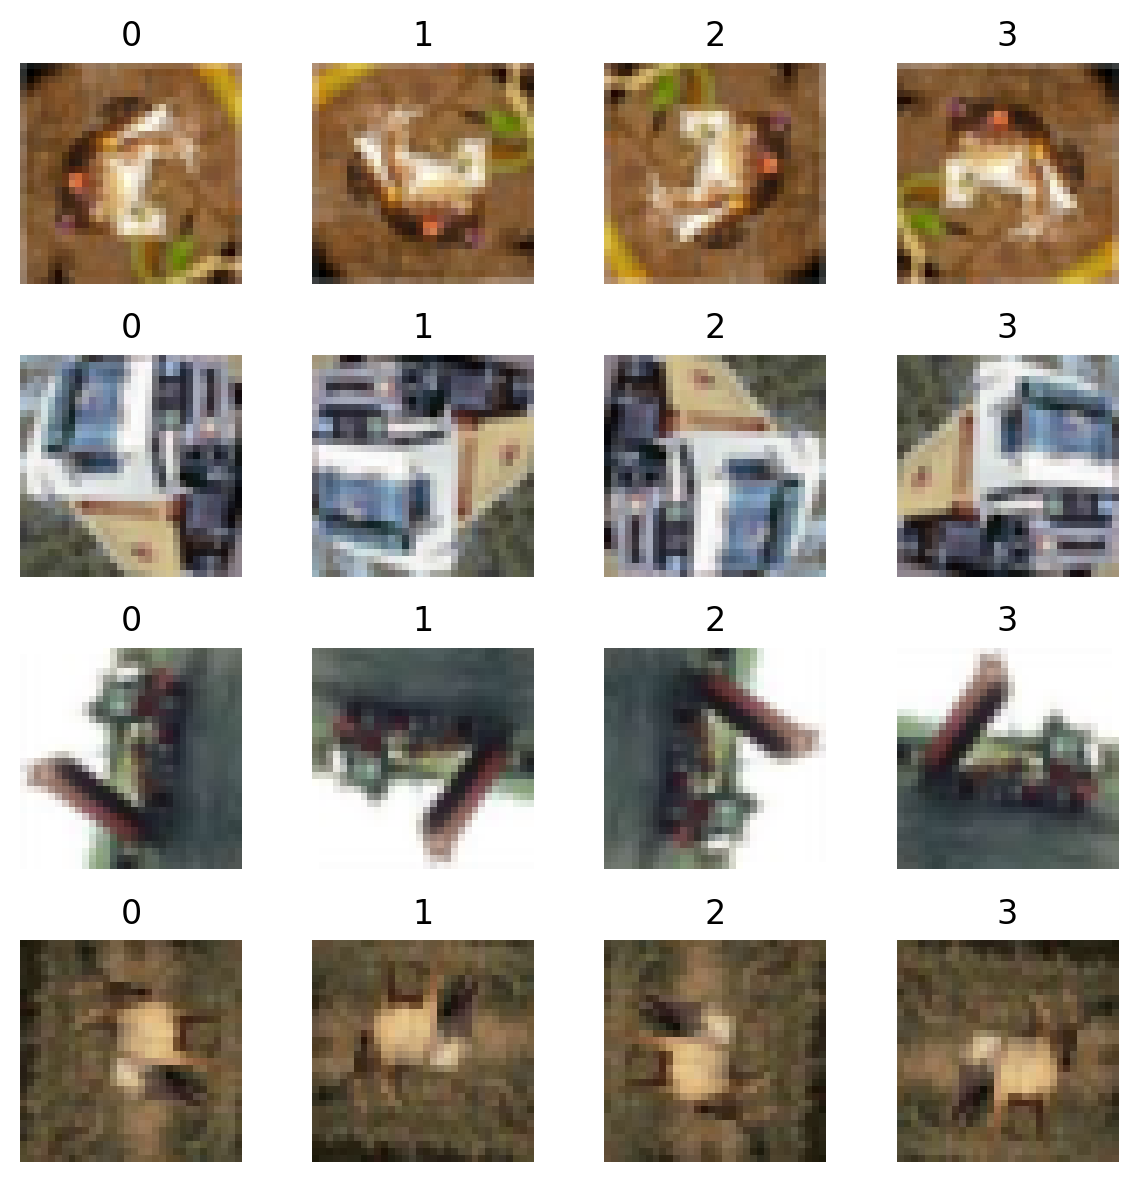

In [300]:
# View the images
plt.figure(figsize=(6, 6))
n_imgs = 16
for i in range(n_imgs):
    plt.subplot(n_imgs//4, 4, i+1)
    plt.imshow(X_ssl[i].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title(y_ssl[i].item())
plt.tight_layout()

In [301]:

class AngleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 4) # 84 input features, 4 output features

    def forward(self, x):
        x = F.gelu(self.fc1(x)) # fc1 -> relu
        x = F.gelu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class SSLAngle(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = AngleClassifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
    

In [302]:
ssl_angle = SSLAngle().to(device)

In [303]:
res_dict = train_fn(ssl_angle, X_ssl, y_ssl, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=200)

Loss: 1.072848: 100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


In [304]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = Net().to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())

res_dict = train_fn(net_pretrained, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)


Loss: 0.001218: 100%|██████████| 500/500 [00:02<00:00, 211.46it/s]


Accuracy Test: 20.30%
Accuracy Train: 100.00%


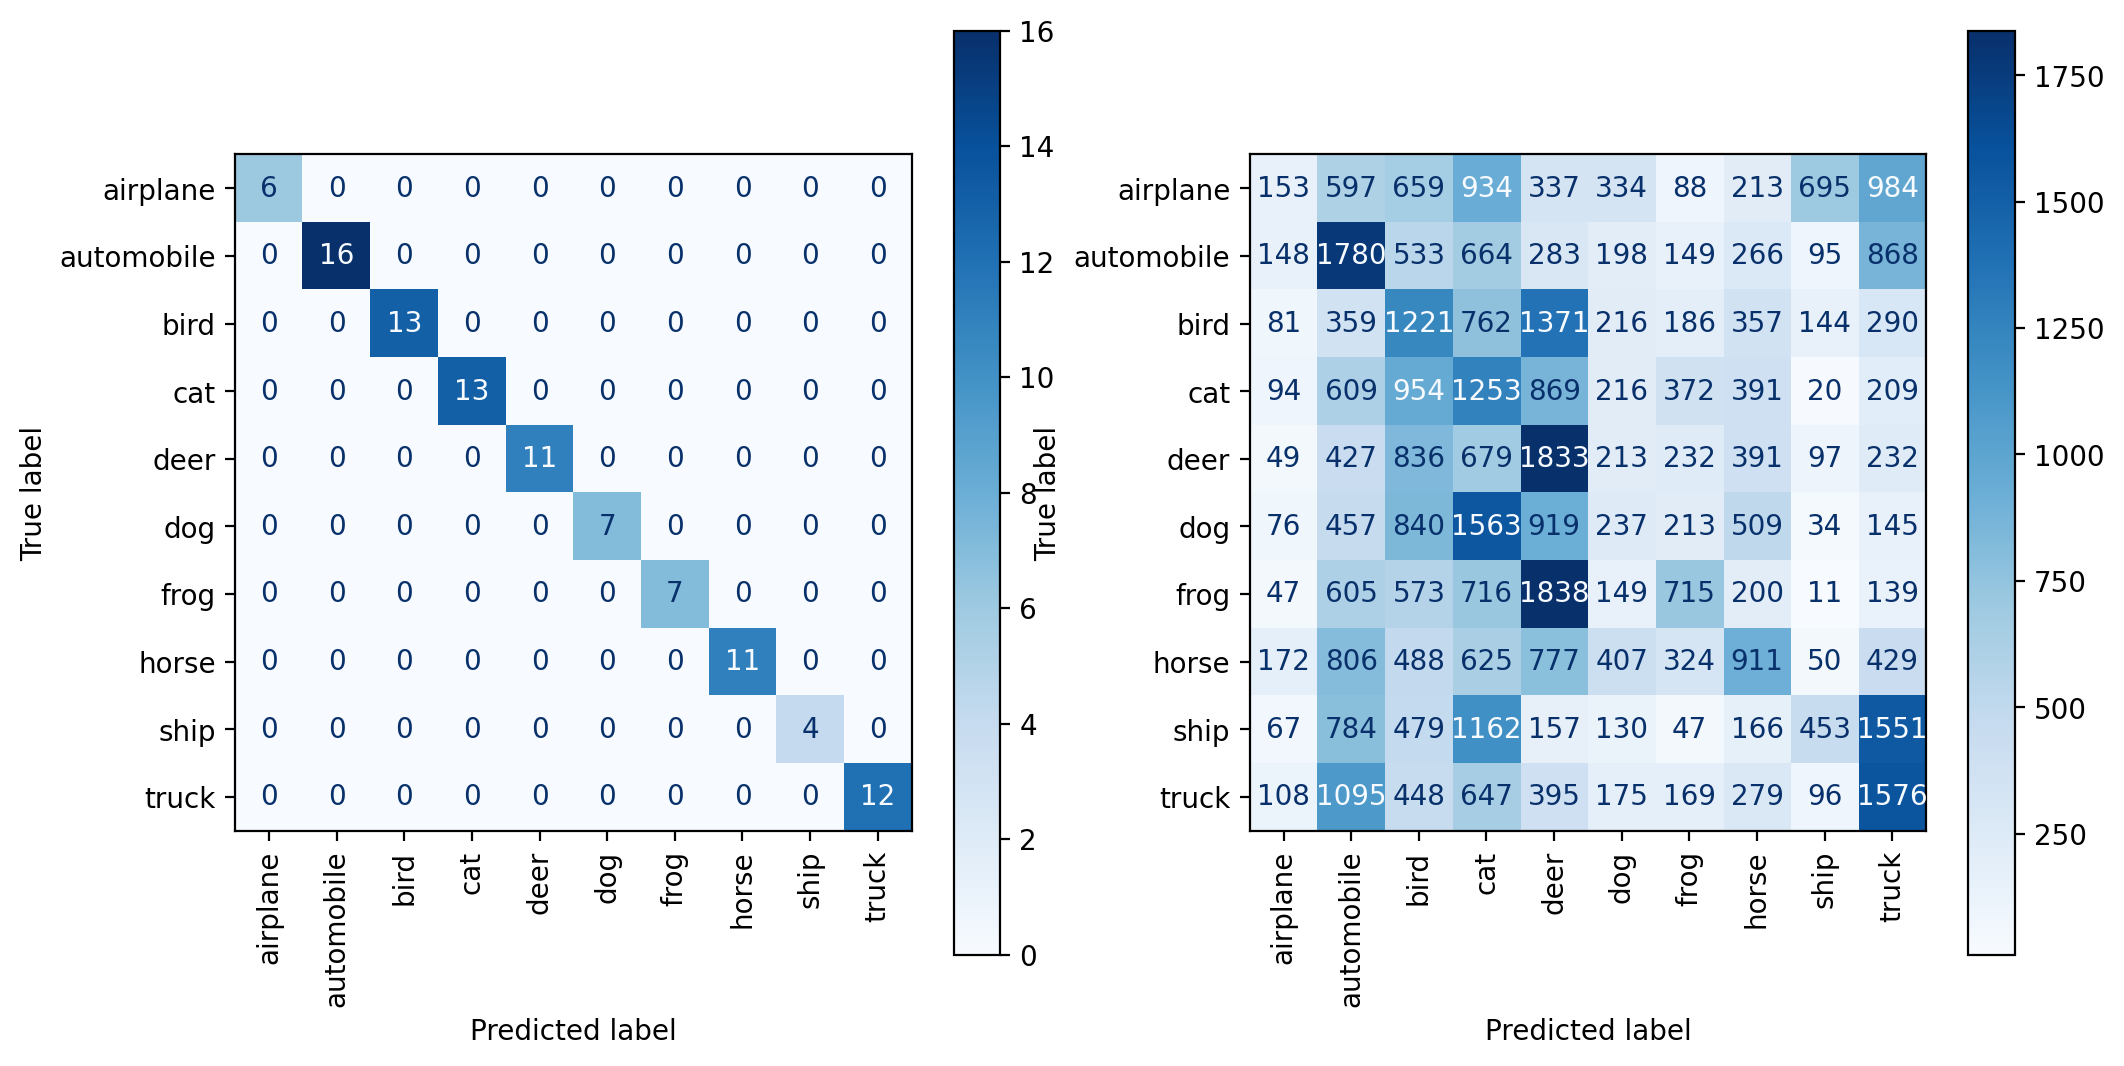

In [305]:
predict(net_pretrained)

In [87]:
# Print layer names, numel and parameters in each layer for "rn"

def print_layer_info(net):
    for name, param in net.named_parameters():
        print(f"Layer: {name}, Numel: {param.numel()}, Parameters: {param.shape}")

print_layer_info(rn)

Layer: conv1.weight, Numel: 9408, Parameters: torch.Size([64, 3, 7, 7])
Layer: bn1.weight, Numel: 64, Parameters: torch.Size([64])
Layer: bn1.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.conv1.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.0.bn1.weight, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.bn1.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.conv2.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.0.bn2.weight, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.0.bn2.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.1.conv1.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.1.bn1.weight, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.1.bn1.bias, Numel: 64, Parameters: torch.Size([64])
Layer: layer1.1.conv2.weight, Numel: 36864, Parameters: torch.Size([64, 64, 3, 3])
Layer: layer1.1.bn2.weight, Numel: 64, Parameters: torch.Size([64])
Layer: lay

In [88]:
feature_extractor = timm.create_model('resnet18', features_only=True)


In [93]:
# Get the features from the feature extractor
with torch.no_grad():
    features = feature_extractor(X_train[:1].cpu())

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [94]:
f = feature_extractor(torch.randn(1, 3, 32, 32).cpu())

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [95]:
# Create the feature extractor
feature_extractor = timm.create_model('resnet18', features_only=True)

# Modify the input to match the expected size (e.g., 224x224)
input_tensor = torch.randn(1, 3, 224, 224)  # Assuming RGB images with a size of 224x224

# Ensure you are working on the CPU
f = feature_extractor(input_tensor.cpu())

In [101]:
len(f)

5

In [104]:
for m in timm.list_models():
    print(m)

bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convformer_s36
convit_base
conv

In [105]:
rn2 =  timm.create_model('resnet18', pretrained=False)


Linear(in_features=512, out_features=1000, bias=True)

In [17]:
# Create a custom featurizer based on ResNet
class ResNetFeaturizer(nn.Module):
    def __init__(self):
        super(ResNetFeaturizer, self).__init__()
        # Create a ResNet feature extractor from the timm library
        feature_extractor = timm.create_model('resnet18', pretrained=True)
        feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])  # Remove the final classification layers
        # add a FC layer to make the output size 400
        self.act = nn.GELU()
        self.linear = nn.Linear(512, 400)
        # Add self.linear as the last layer of the feature extractor
        feature_extractor = nn.Sequential(
            feature_extractor,
            self.act,
            self.linear
        )
        self.feature_extractor = feature_extractor
        
    def forward(self, x):
        return self.feature_extractor(x)
    
class ResNetClassification(nn.Module):
    def __init__(self):
        super(ResNetClassification, self).__init__()
        self.featurizer = ResNetFeaturizer()
        self.classifier = Classifier()
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [18]:
rf = ResNetFeaturizer().to(device)
rf(torch.randn(1, 3, 224, 224).to(device)).shape

torch.Size([1, 400])

In [27]:
rn = ResNetClassification().to(device)
rn(torch.randn(1, 3, 32, 32).to(device)).shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [21]:
class ResNetFeaturizer(nn.Module):
    def __init__(self):
        super(ResNetFeaturizer, self).__init__()
        # Create a ResNet feature extractor from the timm library
        feature_extractor = timm.create_model('resnet18', pretrained=False)
        feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])  # Remove the final classification layers
        self.act = nn.GELU()
        self.linear = nn.Linear(512, 400)
        feature_extractor = nn.Sequential(
            feature_extractor,
            self.act,
            self.linear
        )
        self.feature_extractor = feature_extractor

    def forward(self, x):
        return self.feature_extractor(x)

class ResNetClassification(nn.Module):
    def __init__(self):
        super(ResNetClassification, self).__init__()
        self.featurizer = ResNetFeaturizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        print(x.shape)
        x = self.classifier(x)
        return x

# Set a consistent input size of 32x32 for both models
rf = ResNetFeaturizer().to(device)
rf(torch.randn(1, 3, 32, 32).to(device)).shape

rn = ResNetClassification().to(device)
rn(torch.randn(1, 3, 32, 32).to(device)).shape


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [20]:
f = ResNetFeaturizer().to(device)
f(torch.randn(1, 3, 32, 32).to(device)).shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])